<a href="https://colab.research.google.com/github/Nell87/drivendata_richter/blob/main/script/01_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Overview**
# **Automatic EDA**
# **Manual EDA**
## **Location features**

# **Overview** 
Based on aspects of building location and construction, **our goal is to predict the level of damage to buildings** caused by the 2015 Gorkha earthquake in Nepal.

The data was collected through surveys by Kathmandu Living Labs and the Central Bureau of Statistics, which works under the National Planning Commission Secretariat of Nepal. This survey is one of the largest post-disaster datasets ever collected, containing valuable information on earthquake impacts, household conditions, and socio-economic-demographic statistics.

In [1]:
####    INCLUDES  _______________________________________ #### 
#Loading Libraries:# 
import pandas as pd
import os
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import *

####    READING TRAIN AND TEST DATA _______________________________________ #### 
train_values= data = pd.read_csv("https://raw.githubusercontent.com/Nell87/drivendata_richter/main/data/train_values.csv",index_col='building_id')
train_labels = pd.read_csv("https://raw.githubusercontent.com/Nell87/drivendata_richter/main/data/train_labels.csv",index_col='building_id')
train_merge = train_values.merge(train_labels, on = 'building_id', how = 'inner',)
test = pd.read_csv("https://raw.githubusercontent.com/Nell87/drivendata_richter/main/data/test_values.csv",index_col='building_id')
print(train_merge.shape)

(260601, 40)


# **Automatic EDA**
An useful Python module to quickly do an exploratory analysis is "Pandas Profiling". With just a few lines of code you obtain an interactive report with an overview and alerts. 

In this report we can confirm that there aren't missing values or duplicates. 

```
# Install the python module
pip install pandas_profiling

# Import Pandas Profiling
from pandas_profiling import ProfileReport

# Generate the report
profile = ProfileReport(train_merge, title="Profiling Report")

# Export the report to html file
profile.to_file("Profiling Report.html")
```

![](https://drive.google.com/uc?export=view&id=1QW5kZvHvB_kogLVbw1fqudesqpWO57SR)

# **Manual EDA**
After generating the automatic EDA, let's manually analyze interesting features that could have an impact when building our model. 

The dataset has information about the building structure, use cases, area, location, age and legal ownership. Each row represents a specific building in the region that was hit by Gorkha earthquake.The train dataset has 260,601 rows and the test dataset has 86,868 rows. Both have 38 features to predict the level of damage to every building (the damage_grade feature).

In [3]:
train_merge.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

## **Manual EDA: Target feature or damage_grade**
Almost 60% of the buildings suffer a medium amount of damage, followed by high with around 30% and low with around 10%. Therefore, we deal with imbalanced data. It makes sense since the earthquake had a strong magnitude, 7.8,  in a country where the buildings are more prone to be weak in structure. In a richer country, like Japan or California, earquakes of this magnitude is not usually a giant disaster.

In [4]:
train_merge['damage_grade'].value_counts(normalize=True) * 100     # High 33.46, Medium 56.90, Low 9.64


2    56.891186
3    33.468022
1     9.640792
Name: damage_grade, dtype: float64

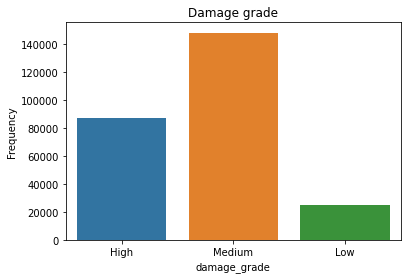

In [5]:
# Add labels
damage_map = {1:"Low", 2:"Medium", 3:"High"}
train_merge["damage_grade"] = train_merge["damage_grade"].map(damage_map)

sns.countplot(x="damage_grade", data=train_merge)
plt.title("Damage grade")
plt.ylabel('Frequency')
plt.show()

## **Manual EDA: Numerical features**
We identify four numerical features:count_families, count_floors_pre_eq, age, area_percentage and height_percentage

All distributions indicates the existence of outliers values that could reduce the accuracy of the models. So we'll remove them.  

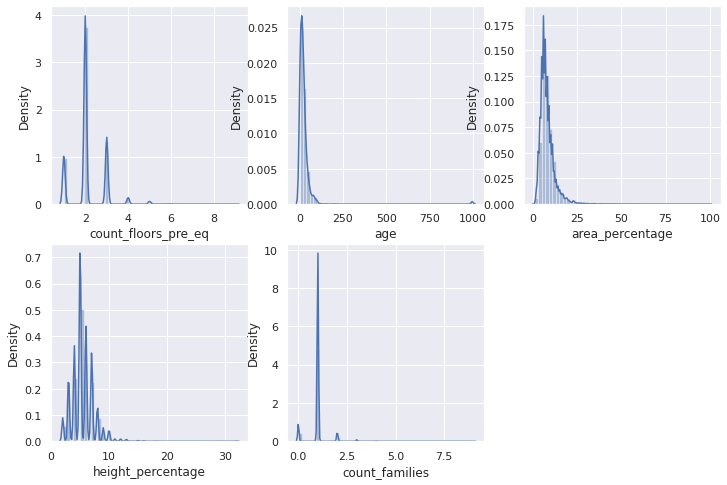

In [6]:
warnings.filterwarnings('ignore')
sns.set(rc={"figure.figsize": (12, 8)}); np.random.seed(0)

count_floors_pre_eq = train_merge["count_floors_pre_eq"]
age = train_merge["age"]
area_percentage = train_merge["area_percentage"]
height_percentage = train_merge["height_percentage"]
count_families = train_merge["count_families"]

subplot(2,3,1)
ax = sns.distplot(count_floors_pre_eq)

subplot(2,3,2)
ax = sns.distplot(age)

subplot(2,3,3)
ax = sns.distplot(area_percentage)

subplot(2,3,4)
ax = sns.distplot(height_percentage)

subplot(2,3,5)
ax = sns.distplot(count_families)

plt.show()

#### **Manual EDA: Numerical features - count_families**
Number of families that live in the building.
Having betwen 0 and 3 families living in a building represents ~98% of data, so we'll get rid of buildings with higher number of families. 


In [7]:
count_families_data = train_merge[["count_families", "damage_grade"]]
count_families_data["count_families"] = pd.Categorical(count_families_data["count_families"])
count_families_data["count_families"].value_counts(normalize=True)

1    0.867667
0    0.080053
2    0.043338
3    0.006915
4    0.001493
5    0.000399
6    0.000084
7    0.000027
9    0.000015
8    0.000008
Name: count_families, dtype: float64

#### **Manual EDA: Numerical features - count_floors_pre_eq**
Number of floors in the building before the earthquake.
Having 1, 2 or 3 floors represent ~97% of data, so we'll get rid of buildings with higher number of them.

In [8]:
count_floors_data = train_merge[["count_floors_pre_eq", "damage_grade"]]
count_floors_data["count_floors_pre_eq"] = pd.Categorical(count_floors_data["count_floors_pre_eq"])
count_floors_data["count_floors_pre_eq"].value_counts(normalize=True)

2    0.601007
3    0.213418
1    0.155184
4    0.020813
5    0.008619
6    0.000802
7    0.000150
8    0.000004
9    0.000004
Name: count_floors_pre_eq, dtype: float64

#### **Manual EDA: Numerical features - age**
It's the age of the building in years (between 0 and 995 years).Due to its distribution, we'll aply the IQR based removal on this feature, achieving a distribution between 0 and 55 years. 

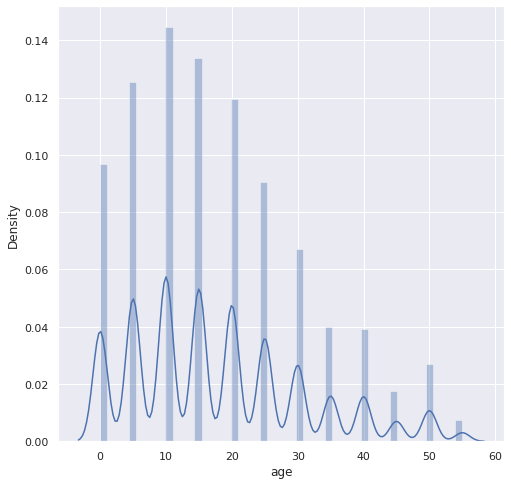

In [ ]:
def rem_outliers_IQR(data, feature):  
  # Finding the IQR
  percentile25 = data[feature].quantile(0.25)
  percentile75 = data[feature].quantile(0.75)
  iqr = percentile75 - percentile25

  # Finding upper and lower limit
  upper_limit = percentile75 + 1.5 * iqr
  lower_limit = percentile25 - 1.5 * iqr

  # Outliers removal
  data = data[data[feature] < upper_limit]
  data = data[data[feature] > lower_limit]

  return data

test = rem_outliers_IQR(train_merge, 'age')
sns.distplot(test['age'])

#### **Manual EDA: Numerical features - area_percentage**
It's the normalized area of the building footprint (1-100). Due to its distribution, we'll aply the IQR based removal on this feature, achieving a distribution between 1 and 14. 

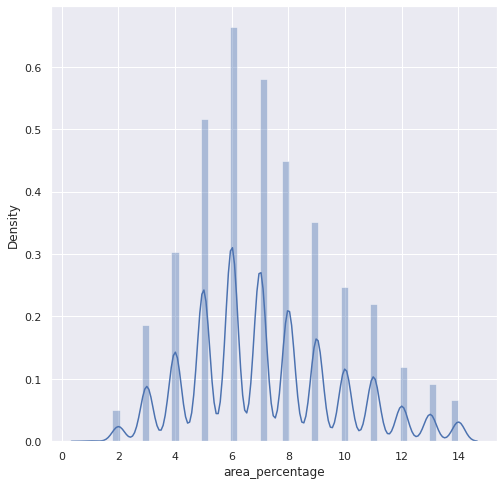

In [ ]:
test = rem_outliers_IQR(train_merge, 'area_percentage')
sns.distplot(test['area_percentage'])

#### **Manual EDA: Numerical features - height_percentage**
It's the normalized height of the building footprint (2-32). Due to its distribution, we'll aply the IQR based removal on this feature, achieving a distribution between 1 and 8.

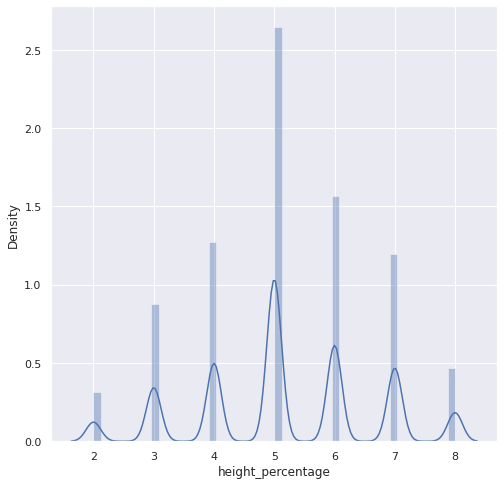

In [ ]:
test = rem_outliers_IQR(train_merge, 'height_percentage')
sns.distplot(test['height_percentage'])

## **Manual EDA: Categorical features**

#### **Manual EDA: Categorical features - Location**
The features **geo_level_1_id, geo_level_2_id, geo_level_3_id** represent the geographic region in which building exists, from largest (level 1) to most specific sub-region (level 3). Possible values: level 1: 0-30, level 2: 0-1427, level 3: 0-12567.

For every location feature there is a high number of categorical values, so we'll apply feature engineering on them. We'll replace every value with their conditional probabilities respect to every damage_grade category (check the "feature selection and feature engineering" colab)

#### **Manual EDA: Categorical features - (More than two levels)**
- land_surface_condition
- foundation_type 
- roof_type 
- ground_floor_type 
- other_floor_type 
- position 
- plan_configuration 
- legal_ownership_status 

#### **Manual EDA: Categorical features - (Two levels)**
There are features related with the materials used. 
- has_superstructure_adobe_mud 
- has_superstructure_mud_mortar_stone 
- has_superstructure_stone_flag 
- has_superstructure_cement_mortar_stone 
- has_superstructure_mud_mortar_brick 
- has_superstructure_cement_mortar_brick 
- has_superstructure_timber
- has_superstructure_bamboo 
- has_superstructure_rc_non_engineered 
- has_superstructure_rc_engineered 
- has_superstructure_other 

There are also features related with the second use. 
- has_secondary_use 
- has_secondary_use_agriculture 
- has_secondary_use_hotel 
- has_secondary_use_rental 
- has_secondary_use_institution 
- has_secondary_use_school 
- has_secondary_use_industry
- has_secondary_use_health_post 
- has_secondary_use_gov_office 
- has_secondary_use_use_police 
- has_secondary_use_other 